In [130]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
import copy
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time

In [141]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import sum_it, data_iterations
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.network import load_model, train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.crp_attribution import CRPAttribution
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

%reload_ext autoreload
%autoreload 2

In [40]:
MODEL_ZOO_INFOS_PATH = "outputs/final_models.json"#"outputs/seeded_model_accuracies.json"
MODEL_NAME = "../clustermodels/final"
with open(MODEL_ZOO_INFOS_PATH, "r") as f:
    modelzoo = json.load(f)


MAX_INDEX = 491520
STEP_SIZE = 40200 # 1033, 2011, 2777, 5381, 7069, 13267, 18181
indices = range(0, MAX_INDEX, STEP_SIZE)
LAYER_NAME = "convolutional_layers.3"
ds = BiasedNoisyDataset()
print(len(indices))

13


In [42]:
from expbasics.visualizations import data_iterations

datas, bis, biases, alldata= data_iterations(MODEL_ZOO_INFOS_PATH, num_it=16)

#[a["train_accuracy"][2] for a in datas[9]]

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


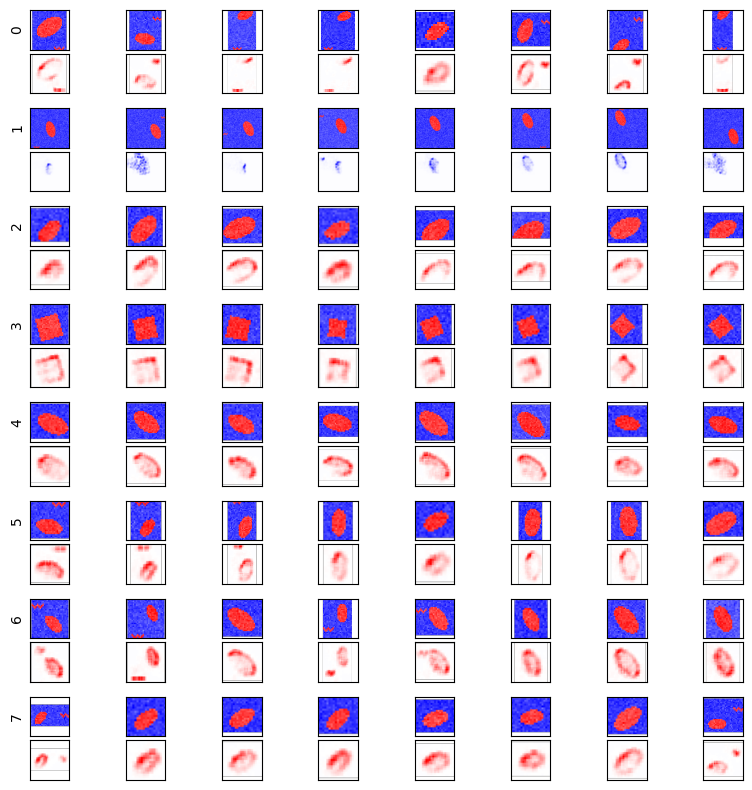

In [82]:
from expbasics.plotting import draw_graph_with_images
model = load_model(MODEL_NAME, 0.85, 4)
model_name = to_name(0.85, 4)
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name)

#nodes, edges, images = crpa.complete_relevance_graph(50)
#draw_graph_with_images(nodes, edges, images)

#res = crpa.compute_feature_vis()

crpa.make_all_references("convolutional_layers.6", range(8)) #"convolutional_layers.6"

(64, 64)
output: tensor([[ 0.7307, -0.2785]]), 
 latents: [0 0 0 0 5], watermark: True, prediction:0 
 convolutional_layers.0: 
 0: -0.12, 1: -0.05, 2: -0.12, 3: 0.28, 4: 0.06, 5: 0.14, 6: -0.1, 7: -0.13 
 convolutional_layers.3: 
 0: -0.08, 1: -0.2, 2: -0.06, 3: -0.09, 4: -0.1, 5: 0.1, 6: -0.31, 7: -0.06 
 convolutional_layers.6: 
 0: 0.13, 1: -0.15, 2: -0.18, 3: 0.25, 4: -0.02, 5: 0.19, 6: 0.07, 7: 0.01 
 linear_layers.0: 
 0: -0.04, 1: -0.17, 2: 0.18, 3: 0.23, 4: 0.17, 5: 0.21 
 linear_layers.2: 
 0: 0.72, 1: -0.28 


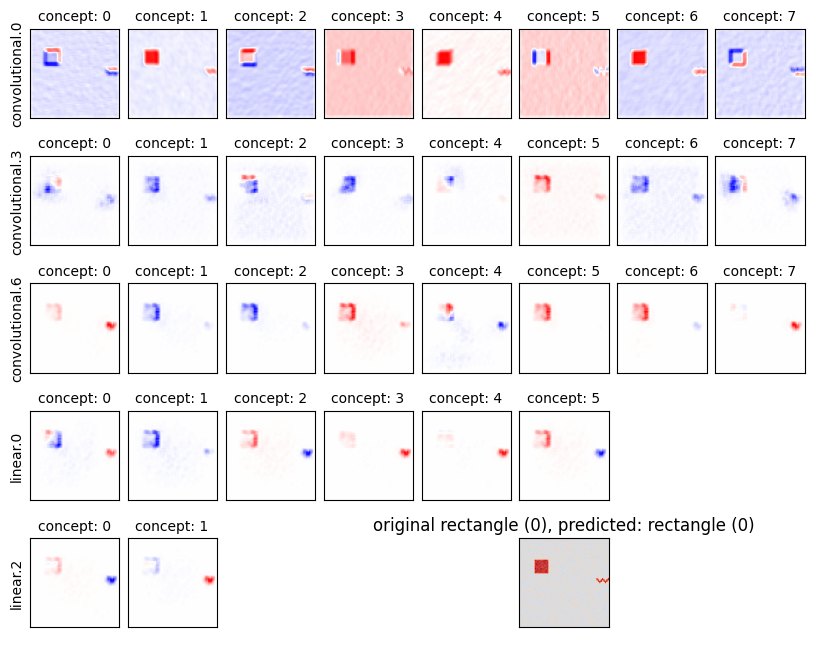

In [84]:
rel = crpa.image_info(5, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

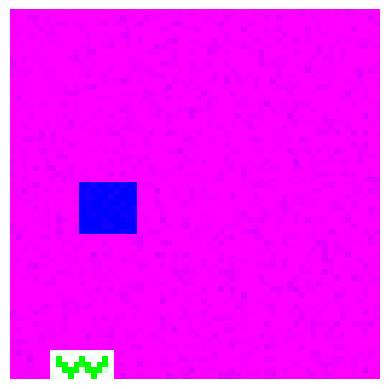

In [80]:
res = crpa.watermark_importance(50)
image = copy.deepcopy(ds[50][0])
img = torch.zeros(64,64,3)
img[:,:,0] = (image[0] * -1) + 1
img[:,:,2] = (image[0] * res["mask"] * -1) + 1
img[np.where(res["mask"] == 1)[0],np.where(res["mask"] == 1)[1],1] = 1
plt.imshow(img)
plt.axis("off")

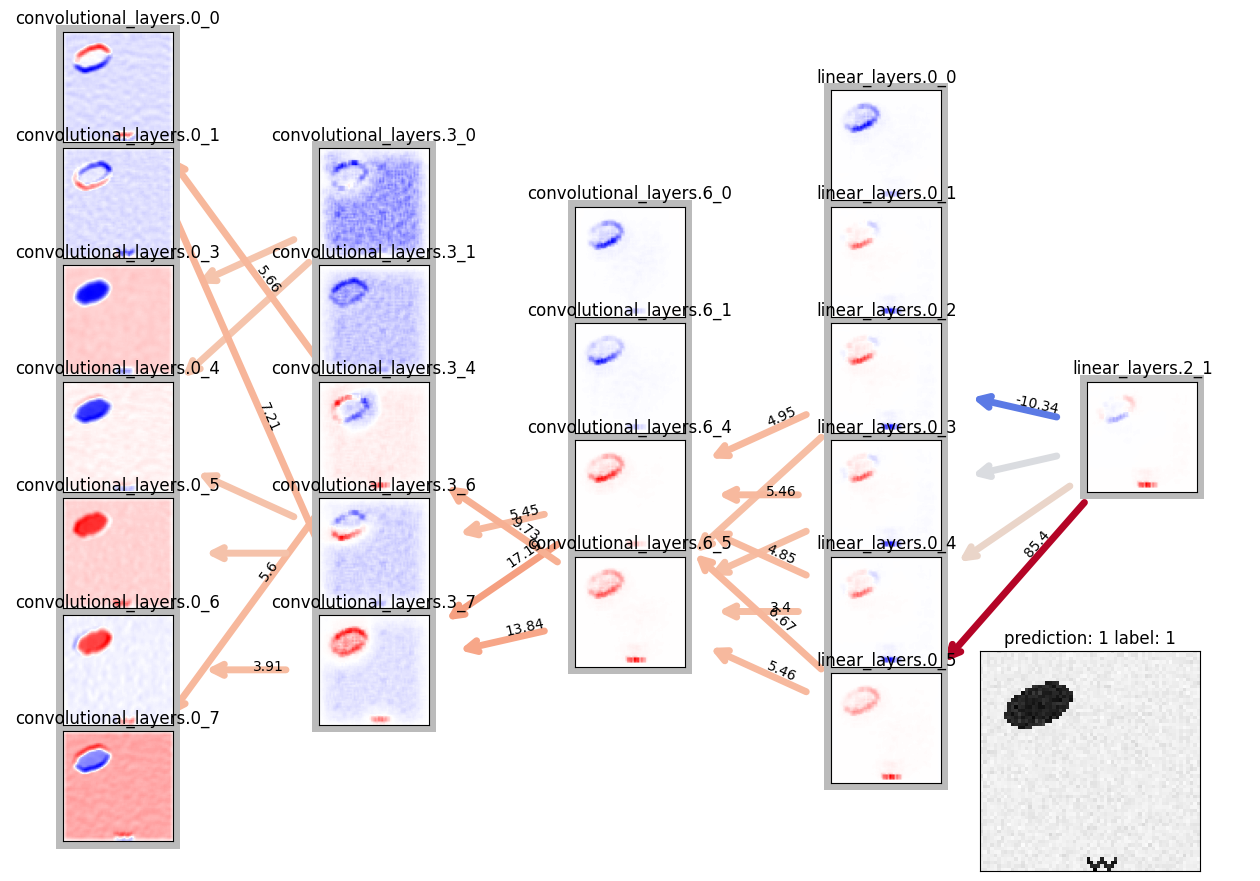

In [84]:
model = load_model(MODEL_NAME, 0.9, 3)
model_name = to_name(0.9, 3)
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name)

nodes, edges, images = crpa.complete_relevance_graph(391200)
draw_graph_with_images(nodes, edges, images)

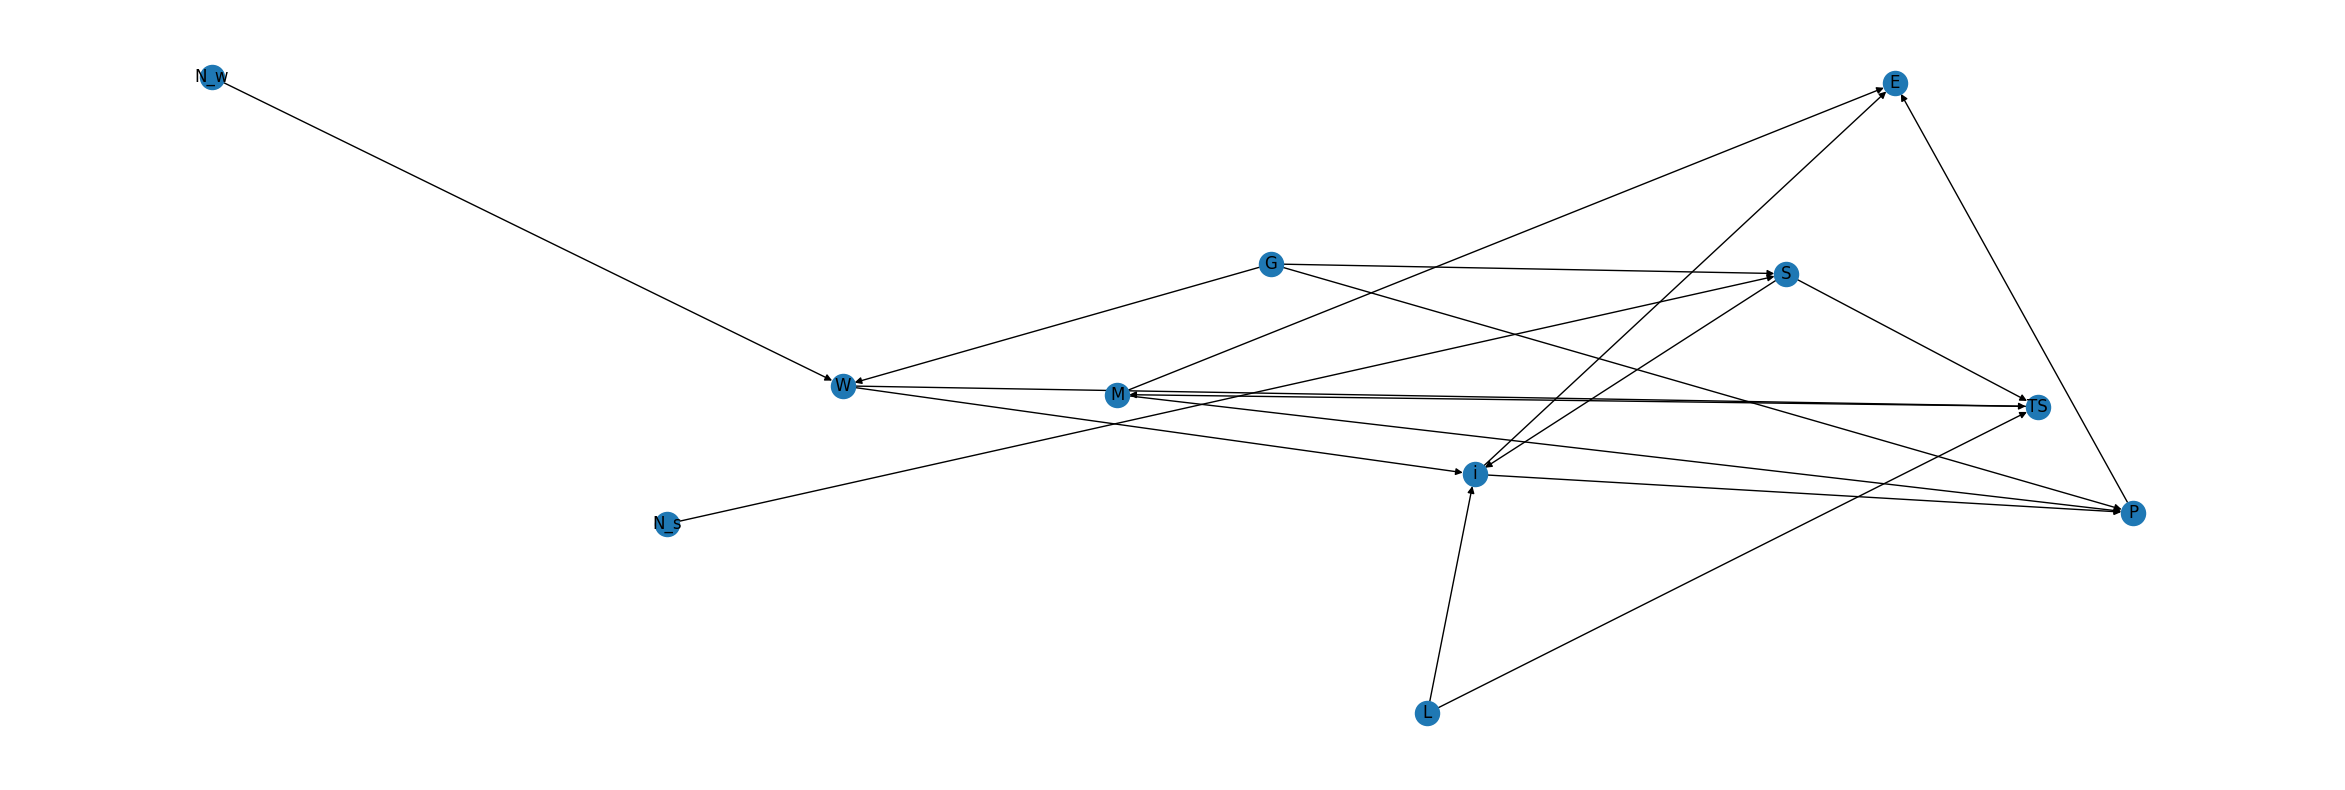

In [49]:

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111, frame_on=False)

nodes = ["N_w", "N_s", "G", "S", "W", "TS", "i", "M", "P", "E"]
edges = [
    ("N_w", "W"),
    ("N_s", "S"),
    ("G", "W"),
    ("G", "S"),
    ("L", "TS"),
    ("L", "i"),
    ("W", "TS"),
    ("W", "i"),
    ("S", "TS"),
    ("S", "i"),
    ("TS", "M"),
    ("M", "P"),
    ("i", "P"),
    ("G", "P"),
    ("P", "E"),
    ("i", "E"),
    ("M", "E"),
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx(
    G,
    ax=ax,
    pos=pos,
)

output: tensor([[ 1.7637, -1.9088]]), 
 latents: [ 0  0  0 12 16], watermark: True, prediction:0 
 convolutional_layers.0: 
 0: -0.11, 1: -0.08, 2: -0.13, 3: 0.26, 4: 0.04, 5: 0.14, 6: -0.12, 7: -0.12 
 convolutional_layers.3: 
 0: -0.05, 1: -0.17, 2: -0.08, 3: -0.07, 4: -0.15, 5: 0.11, 6: -0.35, 7: -0.02 
 convolutional_layers.6: 
 0: 0.06, 1: -0.12, 2: -0.17, 3: 0.34, 4: -0.08, 5: 0.13, 6: -0.01, 7: -0.1 
 linear_layers.0: 
 0: -0.09, 1: -0.2, 2: 0.36, 3: 0.01, 4: 0.03, 5: 0.3 
 linear_layers.2: 
 0: 0.48, 1: -0.52 


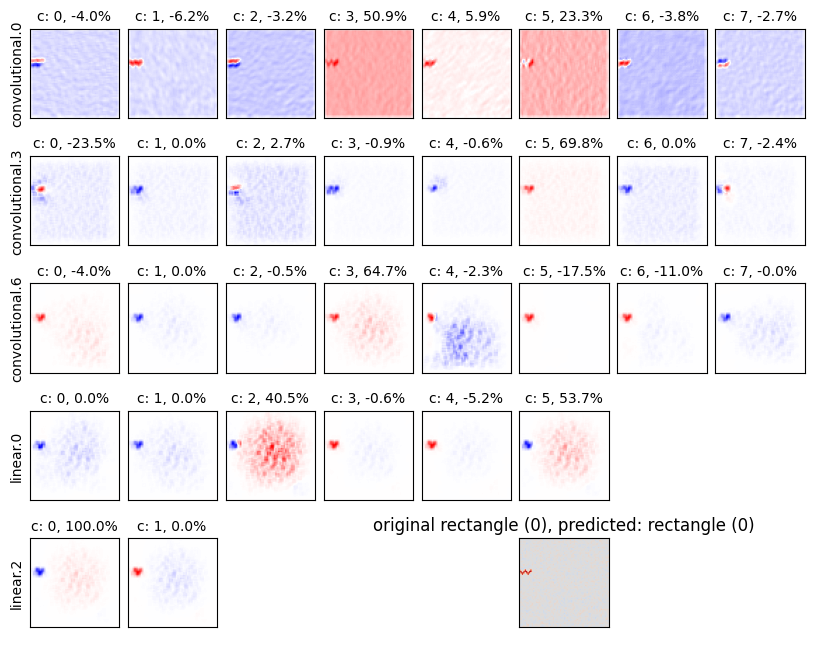

In [111]:
res =crpa.image_info(400,verbose=True, onlywm=True)

In [79]:
gm = GroundTruthMeasures(ds, step_size=18181)
cc = ChannelConcept()


def get_test_accuracy(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    func = gm.get_value_computer(LAYER_NAME, model, "complete_heatmaps")
    # func = gm.get_output
    diffs = []
    crp_attribution = CRPAttribution(
        model, ds, MODEL_NAME, to_name(item["bias"], item["num_it"])
    )
    for ix in indices:
        hms_false = func(ix, False)
        hms_true = func(ix, True)
        rels_true = crp_attribution.get_reference_scores(ix, True, LAYER_NAME)
        testreal = torch.sum(hms_true.view(*hms_true.shape[:1], -1), dim=-1)
        testreal = testreal / (torch.abs(testreal).sum(-1).view(-1, 1) + 1e-10)
        #print(rels_true == testreal)
        # rels_false = crp_attribution.get_reference_scores(ix, False, LAYER_NAME)
        # hms_false = func(ix,model, False)
        # hms_true = func(ix,model, True)
        diff = torch.sum(
            torch.abs(
                (hms_true - hms_false)  # * torch.abs(rels_false[:, None, None])
                * torch.abs(rels_true[:, None, None])
            )
        )  # * rels_true[:,None,None]
        # * rels_false[:, None, None]
        # diff = torch.sum(torch.abs((hms_true - hms_false)))
        diffs.append(diff)
    return float(np.mean(diffs))


def allacc(modelzoo):
    for k, v in modelzoo.items():
        obs = get_test_accuracy(v)
        modelzoo[k]["mrc_weighted"] = obs
        # modelzoo[k]["mlc"] = obs

    with open("test.json", "w+") as f:
        json.dump(modelzoo, f)
    return modelzoo


observations = allacc(modelzoo)

In [10]:
v1 = torch.tensor([2,3,4,5,-10,-1,4,1,65])
v2 = torch.tensor([-3,1,-7,4,0, 0,23,1,-4])
print(np.linalg.norm(v1-v2), np.sum(np.abs((v1-v2).numpy())))

73.30757123244501 118


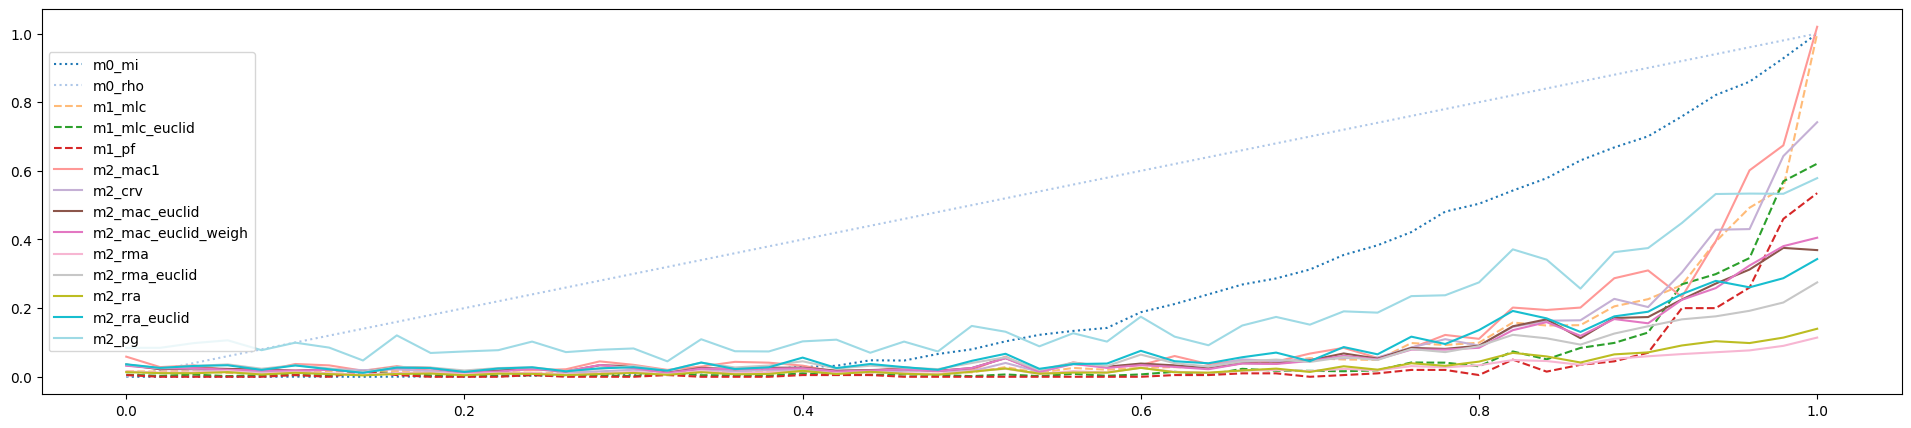

In [79]:
with open("over_rho.json", "r") as f:
    all_vals = json.load(f)
biases = []
mlen = len(all_vals["0.0"].keys())
colors = matplotlib.cm.tab20(np.linspace(0, 1, mlen))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,51))
labels = list(all_vals["0.0"].keys())
for bi, b in enumerate(all_vals.keys()):
    biases.append(float(b))
    for i, (k, item) in enumerate(all_vals[b].items()):
        vals[i, bi] = item
biases = np.array(biases)
plt.figure(figsize=(24,5))
for i, l in enumerate(labels):
    linestyle = "dashed" if l.startswith("m1") else "solid"
    linestyle = "dotted" if l.startswith("m0") else linestyle
    item = vals[i,:]
    if l == "m1_mlc":# or l == "m2_mac1":
        item = vals[i,:] / (vals[i,:].max() + 1e-10)
    plt.plot(biases,item,label=l, c=colors[i],linestyle=linestyle)
plt.legend(loc="center left")

In [13]:
BIASES = list(np.round(np.linspace(0, 1, 51), 3)) # list(np.round(np.linspace(0, 1, 21), 3))
ITERATIONS = list(range(20))
print(len(BIASES) * 16)

816


/tmp/ipykernel_701309/489168792.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(biases,item,label=label, c=colors[i])


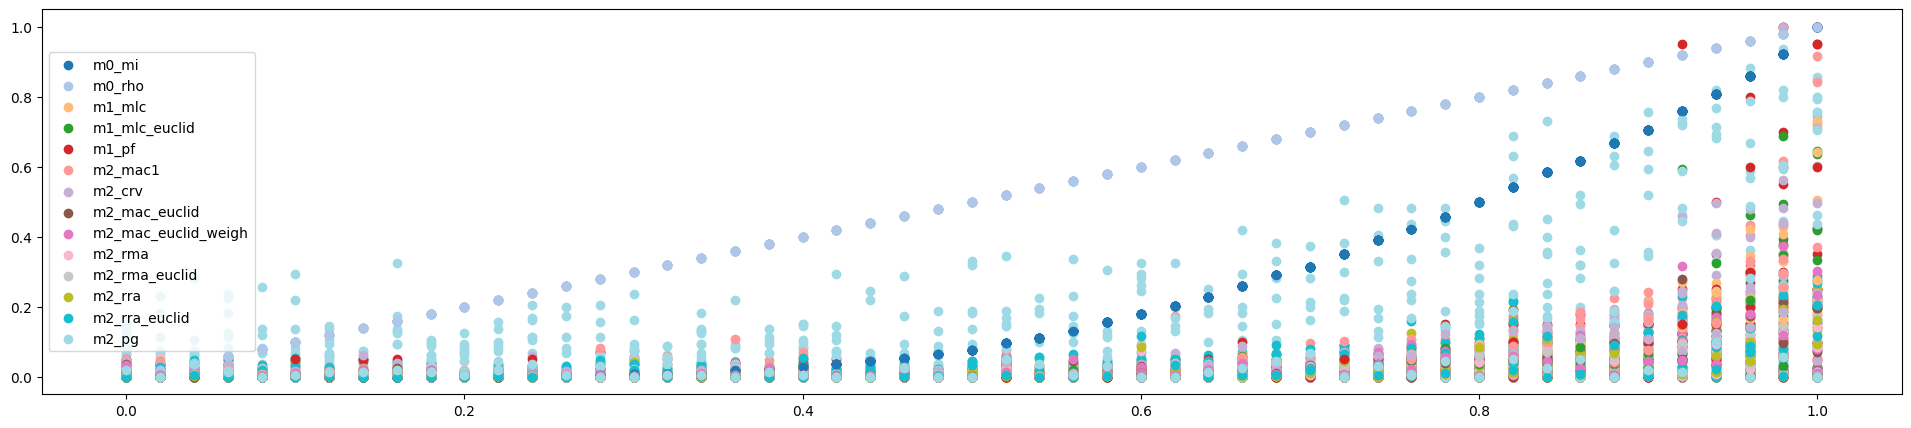

In [85]:
with open("models_values.json", "r") as f:
    all_vals = json.load(f)
biases = []
mlen = len(all_vals["0.0"]["0"].keys())
colors = matplotlib.cm.tab20(np.linspace(0, 1, mlen))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,16,51))
labels = list(all_vals["0.0"]["0"].keys())
for bi, b in enumerate(all_vals.keys()):
    biases.append(float(b))
    for num_it in all_vals[b].keys():
        for i, (k, item) in enumerate(all_vals[b][num_it].items()):
            vals[i,int(num_it), bi] = item
biases = np.array(biases)
plt.figure(figsize=(24,5))
for n in range(16):
    for i, l in enumerate(labels):
        if "cosine" not in l:
            item = vals[i,n,:]
            if "euclid" in l:
                item = vals[i,n,:] / 2#(vals[i,:].max() + 1e-10)
            if  l in ["m1_mlc","m1_pf", "m2_crv", "m2_mac1", "m2_rma_val"]:
                item = vals[i,n,:] / (vals[i,:].max() + 1e-10)
            label = l if n == 0 else ""
            plt.scatter(biases,item,label=label, c=colors[i])
plt.legend(loc="center left")

In [122]:
with open("models_values.json", "r") as f:
    all_vals = json.load(f)

observations = []
labels = ["m0_rho", "m0_mi","m1_mlc_euclid", "m2_mac_euclid", ] # list(all_vals["0.0"]["0"].keys())

for bi, b in enumerate(all_vals.keys()):
    for num_it in all_vals[b].keys():
        xitem = []
        for l in labels:
            x = all_vals[b][num_it][l]
            xitem.append(x)
        xitem.append(float(num_it))
        observations.append(xitem)
observations = np.array(observations)
variables = labels + ["seed"]
variables = np.array(variables)
#print(observations)
types = np.array([0 for i in range(len(variables))])
types[-1] = 1
types[0] = 0
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True) #, delete_constant=False

all variables: (5,),
 non-constant variables: (5,),            
 shape of dataset: (816, 5) 
 var names = ['m0_rho' 'm0_mi' 'm1_mlc_euclid' 'm2_mac_euclid' 'seed']


[0, 64300, 128600, 192900, 257200, 321500, 385800, 450100]


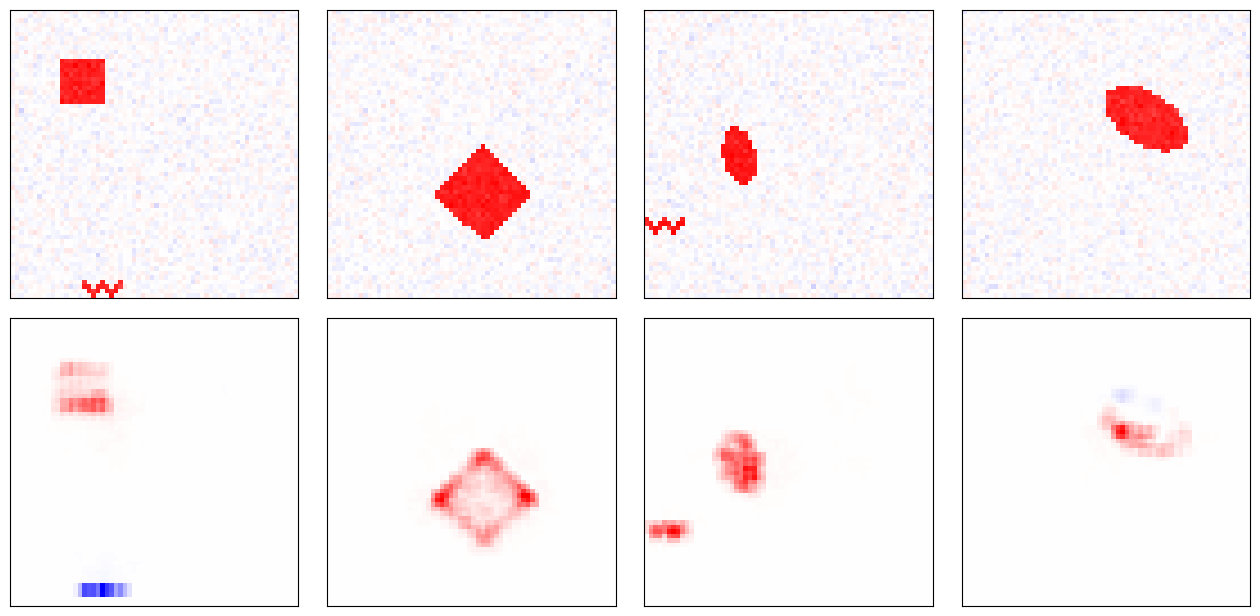

In [237]:
from expbasics.visualizations import my_plot_grid

indices = range(0, MAX_INDEX, 64300)
print(list(indices))
images = torch.zeros(2, 4, 64, 64)
for i, index in enumerate([0, 128600, 257200, 385800]):
    images[0, i] = ds[index][0]
    images[1, i], pred = crpa.heatmap(index)


my_plot_grid(images, 2, 4, resize=4)

In [ ]:
def get_causal_data_model(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    crp_attribution = CRPAttribution(
        model, ds, MODEL_NAME, to_name(item["bias"], item["num_it"])
    )
    """ def get_all_img_info(index, wm):
        image, target = ds.load_image_wm(index, wm)
        latents, _, _ = ds.get_item_info(index)
        output = model(image) """
    observations = []
    relevances = np.zeros((len(indices), 6))
    outputs = np.zeros((len(indices), 2))
    for i, index in enumerate(indices):
        imin = crp_attribution.crp_wm_bbox_layer(index, LAYER_NAME, absolute=False)
        # refscore = crp_attribution.get_reference_scores(index, True, LAYER_NAME)

        obs = [item["bias"], item["num_it"], imin["label"], int(imin["watermark"])]
        #obs += imin["output"][0]
        # obs += refscore
        relevances[i, :] = np.array(imin["rel_within"])
        outputs[i, :] = np.array(imin["output"][0])
        observations.append(obs)
    relevances_sum = np.sum(np.abs(relevances), axis=0)
    relevances = relevances / (relevances_sum + 1e-10)
    outputs = outputs / (np.sum(np.abs(outputs), axis=0) + 1e-10)
    rel_order = np.argsort(relevances_sum)
    for i, index in enumerate(indices):
        observations[i] += outputs[i].tolist()
        observations[i] += relevances[i, rel_order].tolist()
    return observations


def construct_all_causal_data(modelzoo):
    observations = []
    for k, v in modelzoo.items():
        obs = get_causal_data_model(v)
        observations += obs
    return np.array(observations, dtype=np.float64)


observations = construct_all_causal_data(modelzoo)

variables = [
    "bias",
    "seed",
    "is_ellipse",
    "has_watermark",
    "output_0",
    "output_1",
] + [f"rel_{i}" for i in range(6)]
variables = np.array(variables)
types = np.array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
link_assumptions = (
    {
        0: {(i, 0): "<?-" for i in range(2, 12)},
        1: {(i, 0): "<?-" for i in range(4, 12)},
    }
    | {
        j: {(0, 0): "-?>"} | {(i, 0): "<?-" for i in range(4, 12) if i != j}
        for j in range(2, 4)
    }
    | {
        j: {(i, 0): "-?>" for i in range(0, 4)}
        | {(i, 0): "<?-" for i in range(6, 12) if i != j}
        for j in range(4, 6)
    }
    | {j: {(i, 0): "-?>" for i in range(0, 6)} for j in range(6, 12)}
)
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

In [ ]:
# NO OUTPUT
indices = range(245760, MAX_INDEX, 13267)
LAYER_NAME = "convolutional_layers.6"
def get_causal_data_model(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    crp_attribution = CRPAttribution(
        model, ds, MODEL_NAME, to_name(item["bias"], item["num_it"])
    )
    observations = []
    relevances = np.zeros((len(indices), 8))
    for i, index in enumerate(indices):
        imin = crp_attribution.crp_wm_bbox_layer(index, LAYER_NAME, absolute=False, onlyone=1)
        # refscore = crp_attribution.get_reference_scores(index, True, LAYER_NAME)

        obs = [item["bias"], item["num_it"]]
        #obs += imin["output"][0]
        # obs += refscore
        relevances[i, :] = np.array(imin["rel_within"])
        observations.append(obs)
    relevances_sum = np.max(np.abs(relevances), axis=0)
    relevances = relevances / (np.sum(np.abs(relevances)) + 1e-10)
    rel_order = np.argsort(relevances_sum)
    for i, index in enumerate(indices):
        observations[i] += relevances[i, rel_order].tolist()
    return observations


def construct_all_causal_data(modelzoo):
    observations = []
    for k, v in modelzoo.items():
        obs = get_causal_data_model(v)
        observations += obs
    return np.array(observations, dtype=np.float64)


observations = construct_all_causal_data(modelzoo)

variables = [
    "bias",
    "seed",
] + [f"rel_{i}" for i in range(8)]
variables = np.array(variables)
types = np.array([0, 1,  0, 0, 0, 0, 0, 0, 0, 0])
link_assumptions = (
    {
        0: {(i, 0): "<?-" for i in range(2, 10)},
        1: {(i, 0): "<?-" for i in range(2, 10)},
    }
    | {j: {(i, 0): "-?>" for i in range(0, 2)} for j in range(2, 10)}
)
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

In [6]:
# SUMMED ABSOLUTE WATERMARK RELEVANCE
indices = range(0, MAX_INDEX, 13267)
LAYER_NAME = "convolutional_layers.6"


def get_causal_data_model(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    crp_attribution = CRPAttribution(
        model, ds, MODEL_NAME, to_name(item["bias"], item["num_it"])
    )
    observations = []
    relevances = np.zeros((len(indices), 8))
    for i, index in enumerate(indices):
        imin = crp_attribution.crp_wm_bbox_layer(index, LAYER_NAME, absolute=True)
        obs = [item["bias"], item["num_it"], imin["label"], int(imin["watermark"])]
        relevances[i, :] = np.array(imin["rel_within"])
        observations.append(obs)
    for i, index in enumerate(indices):
        observations[i] += [np.sum(relevances[i])]
    return observations


def construct_all_causal_data(modelzoo):
    observations = []
    for k, v in modelzoo.items():
        obs = get_causal_data_model(v)
        observations += obs
    return np.array(observations, dtype=np.float64)


observations = construct_all_causal_data(modelzoo)
variables = ["bias", "seed", "label", "watermark", "wm_abs_rel"]
variables = np.array(variables)
types = np.array([0, 1, 1, 1, 0])
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.81030552e-03]
 ...
 [1.00000000e+00 9.00000000e+00 1.00000000e+00 1.00000000e+00
  1.52459769e-01]
 [1.00000000e+00 9.00000000e+00 1.00000000e+00 1.00000000e+00
  5.11965978e-02]
 [1.00000000e+00 9.00000000e+00 1.00000000e+00 0.00000000e+00
  2.97317599e-03]]
all variables: (5,),
 non-constant variables: (5,),            
 shape of dataset: (7980, 5) 
 var names = ['bias' 'seed' 'label' 'watermark' 'wm_abs_rel']


In [37]:
# AVERAGE CAUSAL EFFECT
# ACE = E[y|do(x=1)] - E[y|do(x=0)]
from expbasics.ground_truth_measures import GroundTruthMeasures
gm = GroundTruthMeasures(ds, step_size=18181)


LAYER_NAME = "convolutional_layers.6"


def get_causal_data_model(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    everything_rma, everything_rra = gm.bounding_box_collection(
        model, LAYER_NAME, disable=True
    )
    everything = everything_rma
    no_wm = list(filter(lambda x: x[1] == 0, everything))
    with_wm = list(filter(lambda x: x[1] == 1, everything))
    topk = torch.topk(torch.sum(torch.tensor([x[2] for x in with_wm]), dim=0), 2)
    print(topk, torch.sum(torch.tensor([x[2] for x in with_wm]), dim=0))
    no_wm_ell = list(filter(lambda x: x[5] == 1, no_wm))
    no_wm_rec = list(filter(lambda x: x[5] == 0, no_wm))
    wm_ell = list(filter(lambda x: x[5] == 1, with_wm))
    wm_rec = list(filter(lambda x: x[5] == 0, with_wm))
    observations = []
    no_wm_ell = np.mean(np.array([x[2] for x in no_wm_ell]), axis=0, dtype=np.float64)
    no_wm_rec = np.mean(np.array([x[2] for x in no_wm_rec]), axis=0, dtype=np.float64)
    wm_ell = np.mean(np.array([x[2] for x in wm_ell]), axis=0, dtype=np.float64)
    wm_rec = np.mean(np.array([x[2] for x in wm_rec]), axis=0, dtype=np.float64)
    observations = [
        [item["bias"], item["num_it"], 1, wm_ell - no_wm_ell],
        [item["bias"], item["num_it"], 0, wm_rec - no_wm_rec],
    ]
    return observations


def construct_all_causal_data(modelzoo):
    observations = []
    for k, v in (pbar := tqdm(modelzoo.items())):
        obs = get_causal_data_model(v)
        observations += obs
        pbar.set_postfix(
            bias=v["bias"],
        )
        break
    return np.array(observations, dtype=np.float64)


observations = construct_all_causal_data(modelzoo)

variables = ["bias", "seed", "label", "wm_abs_rel"]  # "watermark",
variables = np.array(variables)
types = np.array([0, 1, 1, 0])  # 1,
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s, bias=0]

torch.return_types.topk(
values=tensor([0.0449, 0.0417]),
indices=tensor([3, 0])) tensor([0.0417, 0.0270, 0.0000, 0.0449, 0.0378, 0.0405, 0.0030, 0.0279])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 4) + inhomogeneous part.

In [8]:
# SUMMED ABSOLUTE WATERMARK RELEVANCE
indices = range(0, MAX_INDEX, 13267)
LAYER_NAME = "convolutional_layers.6"
BIASES = list(np.round(np.linspace(0, 1, 21), 3))


def get_causal_data_model(item):
    model = load_model(MODEL_NAME, item["bias"], item["num_it"])
    crp_attribution = CRPAttribution(
        model, ds, MODEL_NAME, to_name(item["bias"], item["num_it"])
    )
    observations = []
    for i, index in enumerate(indices):
        # absolute values but all images random
        #imin = crp_attribution.crp_wm_bbox_layer(index, LAYER_NAME, absolute=True)
        # absolute values but all images with watermark
        imin = crp_attribution.crp_wm_bbox_layer(index, LAYER_NAME, absolute=False, onlyone=1)
        rel = np.array(imin["rel_within"])
        obs = [
            item["bias"],
            imin["label"],
            #int(imin["watermark"]),
            np.sum(rel, where=rel > 0),
        ]
        observations.append(obs)
    return np.array(observations)


def construct_all_causal_data(modelzoo):
    observations = []
    for bias in BIASES:
        avg_wm_relevance = None
        for num_it in range(0, 10):
            name = to_name(bias, num_it)
            obs = get_causal_data_model(modelzoo[name])
            if avg_wm_relevance is None:
                avg_wm_relevance = obs/ 10
            else:
                avg_wm_relevance[:, 2] += obs[:, 2] / 10 #3
        observations += avg_wm_relevance.tolist()
    return np.array(observations, dtype=np.float64)


observations = construct_all_causal_data(modelzoo)

variables = ["bias", "label", "wm_abs_rel"]# "watermark",
variables = np.array(variables)
types = np.array([0, 1,  0])#1,
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

all variables: (3,),
 non-constant variables: (3,),            
 shape of dataset: (798, 3) 
 var names = ['bias' 'label' 'wm_abs_rel']


In [74]:
# INTERVENED ACCURACY OVER MODELS

observations = []
for k, v in modelzoo.items():
    obs = [
        v["bias"],
        v["num_it"],
        v["all_wm_accuracy"][0] / 100,
        v["all_wm_accuracy"][1] / 100,
        v["no_wm_accuracy"][0] / 100,
        v["no_wm_accuracy"][1] / 100,
    ]
    obs += v["pred_mlc"]
    obs += v["rma_mlc_linear"][0]
    observations.append(obs)
observations = np.array(observations, dtype=np.float64)
variables = [
    "bias",
    "seed",
    "all_wm_0",
    "all_wm_1",
    "no_wm_0",
    "no_wm_1",
    "mlc_wm",
    "mlc_shape",
    "mlc_scale",
    "mlc_rot",
    "mlc_posx",
    "mlc_posy",
        print(attr.relevances[layer_name].shape, attr.heatmap.shape)
] + [f"rma_{i}" for i in range(6)]
variables = np.array(variables)
types = np.zeros(len(variables))
types[1] = 1
link_assumptions = {
    0: {(i, 0): "<?-" for i in range(2, 18)},
    1: {(i, 0): "<?-" for i in range(2, 18)},
} | {j: {(i, 0): "-?>" for i in range(0, 2)} for j in range(2, 18)}
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=True)

all variables: (18,),
 non-constant variables: (18,),            
 shape of dataset: (210, 18) 
 var names = ['bias' 'seed' 'all_wm_0' 'all_wm_1' 'no_wm_0' 'no_wm_1' 'mlc_wm'
 'mlc_shape' 'mlc_scale' 'mlc_rot' 'mlc_posx' 'mlc_posy' 'rma_0' 'rma_1'
 'rma_2' 'rma_3' 'rma_4' 'rma_5']


In [194]:
# MEAN LOGIT CHANGE OVER MODELS
observations = []
for k, v in modelzoo.items():
    obs = [
        v["bias"],
        v["num_it"],
    ]
    obs += v["pred_mlc"][:1]
    #obs += v["rma_mlc_linear"][0]
    obs += v["rma_mlc_linear"][0]
    print(obs)
    observations.append(obs)
observations = np.array(observations, dtype=np.float64)
variables = [
    "bias",
    "seed",
    "mlc_wm",
    "rma_wm0",
    "rma_wm1",
    "rma_wm2",
    "rma_wm3",
    "rma_wm4",
    "rma_wm5",

    
]# + [f"rma_{i}" for i in range(6)]
""" "mlc_scale",
    "mlc_rot",
    "mlc_posx",
    "mlc_posy",  """
variables = np.array(variables)
types = np.array([0,1,0,0,0,0,0,0,0])
link_assumptions = {
    0: {(i, 0): "<?-" for i in range(2, len(variables))},
    1: {(i, 0): "<?-" for i in range(2, len(variables))},
} | {j: {(i, 0): "-?>" for i in range(0, 2)} | {(i, 0): "o?o" for i in range(2, len(variables)) if i!=j} for j in range(2, len(variables))}
cleaneddf, cleanedvars = remove_empty(observations, variables, types, with_type=False)

[0.0, 0, 0.0022201004781221088, 0.000840226210512858, 0.0039040976767673306, 0.00411199755648053, 0.0, 0.0, 0.033217609684422646]
[0.0, 1, 0.002035228829634817, 0.003325636975683952, 0.0004841894708653471, 0.0, 0.002686359365330454, 0.0, 0.011306611967340455]
[0.0, 2, 0.0027094832376429907, 0.017020239419364626, 0.0, 0.0, 0.010500018131222677, 0.0, 0.015504402623120864]
[0.0, 3, 0.00034440740158683374, 0.0, 0.007608322278874886, 0.007544986180607195, 0.00485417040638487, 0.0050519864075556, 0.013961582114461635]
[0.0, 4, 0.0011823918474347967, 0.0, 0.0, 0.02097158104252709, 0.03617972640588737, 0.03251657409288474, 0.011950577737958443]
[0.0, 5, 0.004741502827719638, 0.031704813827984346, 0.00720796103521599, 0.02971389746235936, 0.0, 0.1391508186708339, 0.013125303152580309]
[0.0, 6, 0.0009378108539079365, 0.0033291440761690624, 0.0, 0.007099270508541322, 0.015833988292318902, 0.013551054633808235, 0.062476102330732065]
[0.0, 7, 0.0029802838046299783, 0.007887455932943436, 0.0, 0.0221

In [123]:
results = causal_discovery(cleaneddf, "CMIknnMixed")#, link_assumptions=link_assumptions)

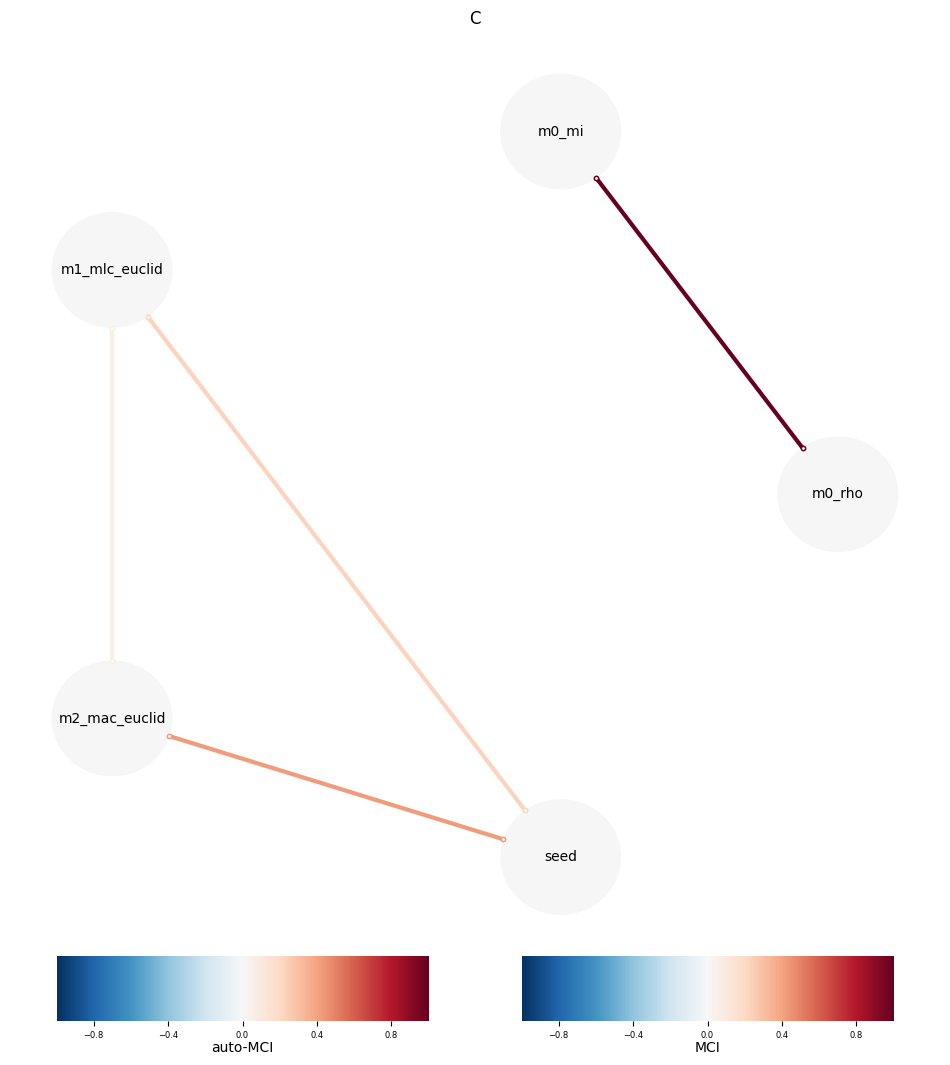

In [124]:
from tigramite import plotting as tp
#node_pos = {"x": [0,0,1,1,0.4,0.7,0.7,0.4, 0.7], "y": [4,2,5,1,2,2.5,3.5,4, 4.5]}
#node_pos = {"x": [0,0,0.4,0.9,0.7,0.9,0.7,0.9,0.7], "y": [4,2,3,5,4,3,2,1,0]}
tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=cleanedvars, #node_pos=node_pos,
                          figsize=(12, 12), arrow_linewidth=3, val_matrix=results["val_matrix"]
                        )
plt.title("C")
plt.show()

[['' '' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->']
 ['' '' '' '' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->']
 ['<--' '' '' '' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->']
 ['<--' '' '' '' '-->' '-->' '-->' '-->' '-->' '-->' '-->' '-->']
 ['<--' '<--' '<--' '<--' '' '' '-->' '-->' '-->' '-->' '-->' '-->']
 ['<--' '<--' '<--' '<--' '' '' '-->' '-->' '-->' '-->' '-->' '-->']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']
 ['<--' '<--' '<--' '<--' '<--' '<--' '' '' '' '' '' '']]


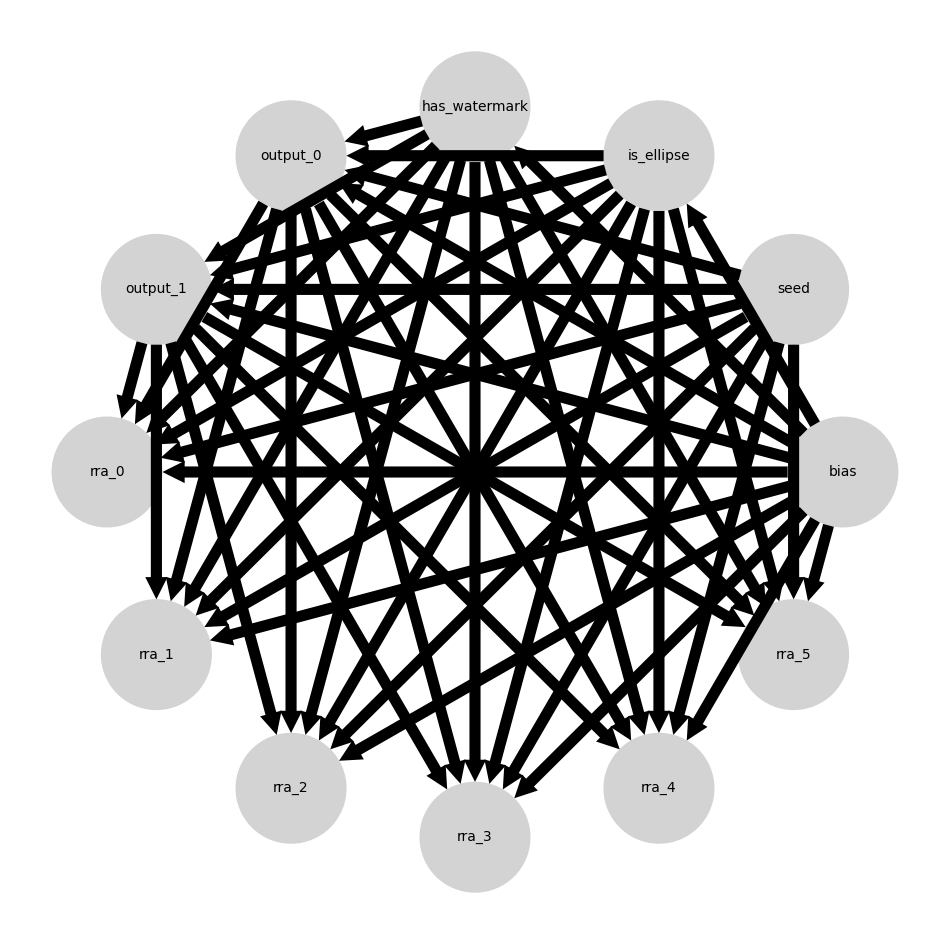

In [127]:
graph_dict = np.array([
    ["" for i in range(13) if j != i] for j in range(12)
],dtype='<U3')
for j, links_j in link_assumptions.items():
    for (i, lag_i), link in link_assumptions[j].items():
        if link == "<?-":
            graph_dict[j][i] = "<--"
        else:
            graph_dict[j][i] = "-->"

print(graph_dict)

tp.plot_graph(
    graph=graph_dict,
    save_name=None,
    var_names=cleanedvars,
    figsize=(12, 12),
)
plt.show()

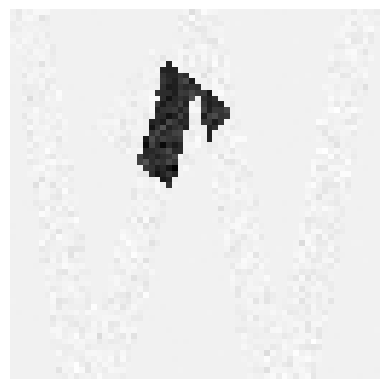

In [170]:
im_frame = Image.open('suppresor.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = (vals +1) % 2
image, wm = ds[200003]

""" image = np.load("../dsprites-dataset/images/200003.npy", mmap_mode="r")
image = torch.from_numpy(np.asarray(image, dtype=np.float32)).view(1, 64, 64) """
p = 0.7
test = image[0]*(p*vals + (1-p)*np.random.normal(0.0, 0.1, (64, 64)))
plt.imshow(test, cmap="Greys")
plt.axis("off")

with open(f"suppressor.npy", "wb") as f:
    np.save(f, vals.numpy(), allow_pickle=True)

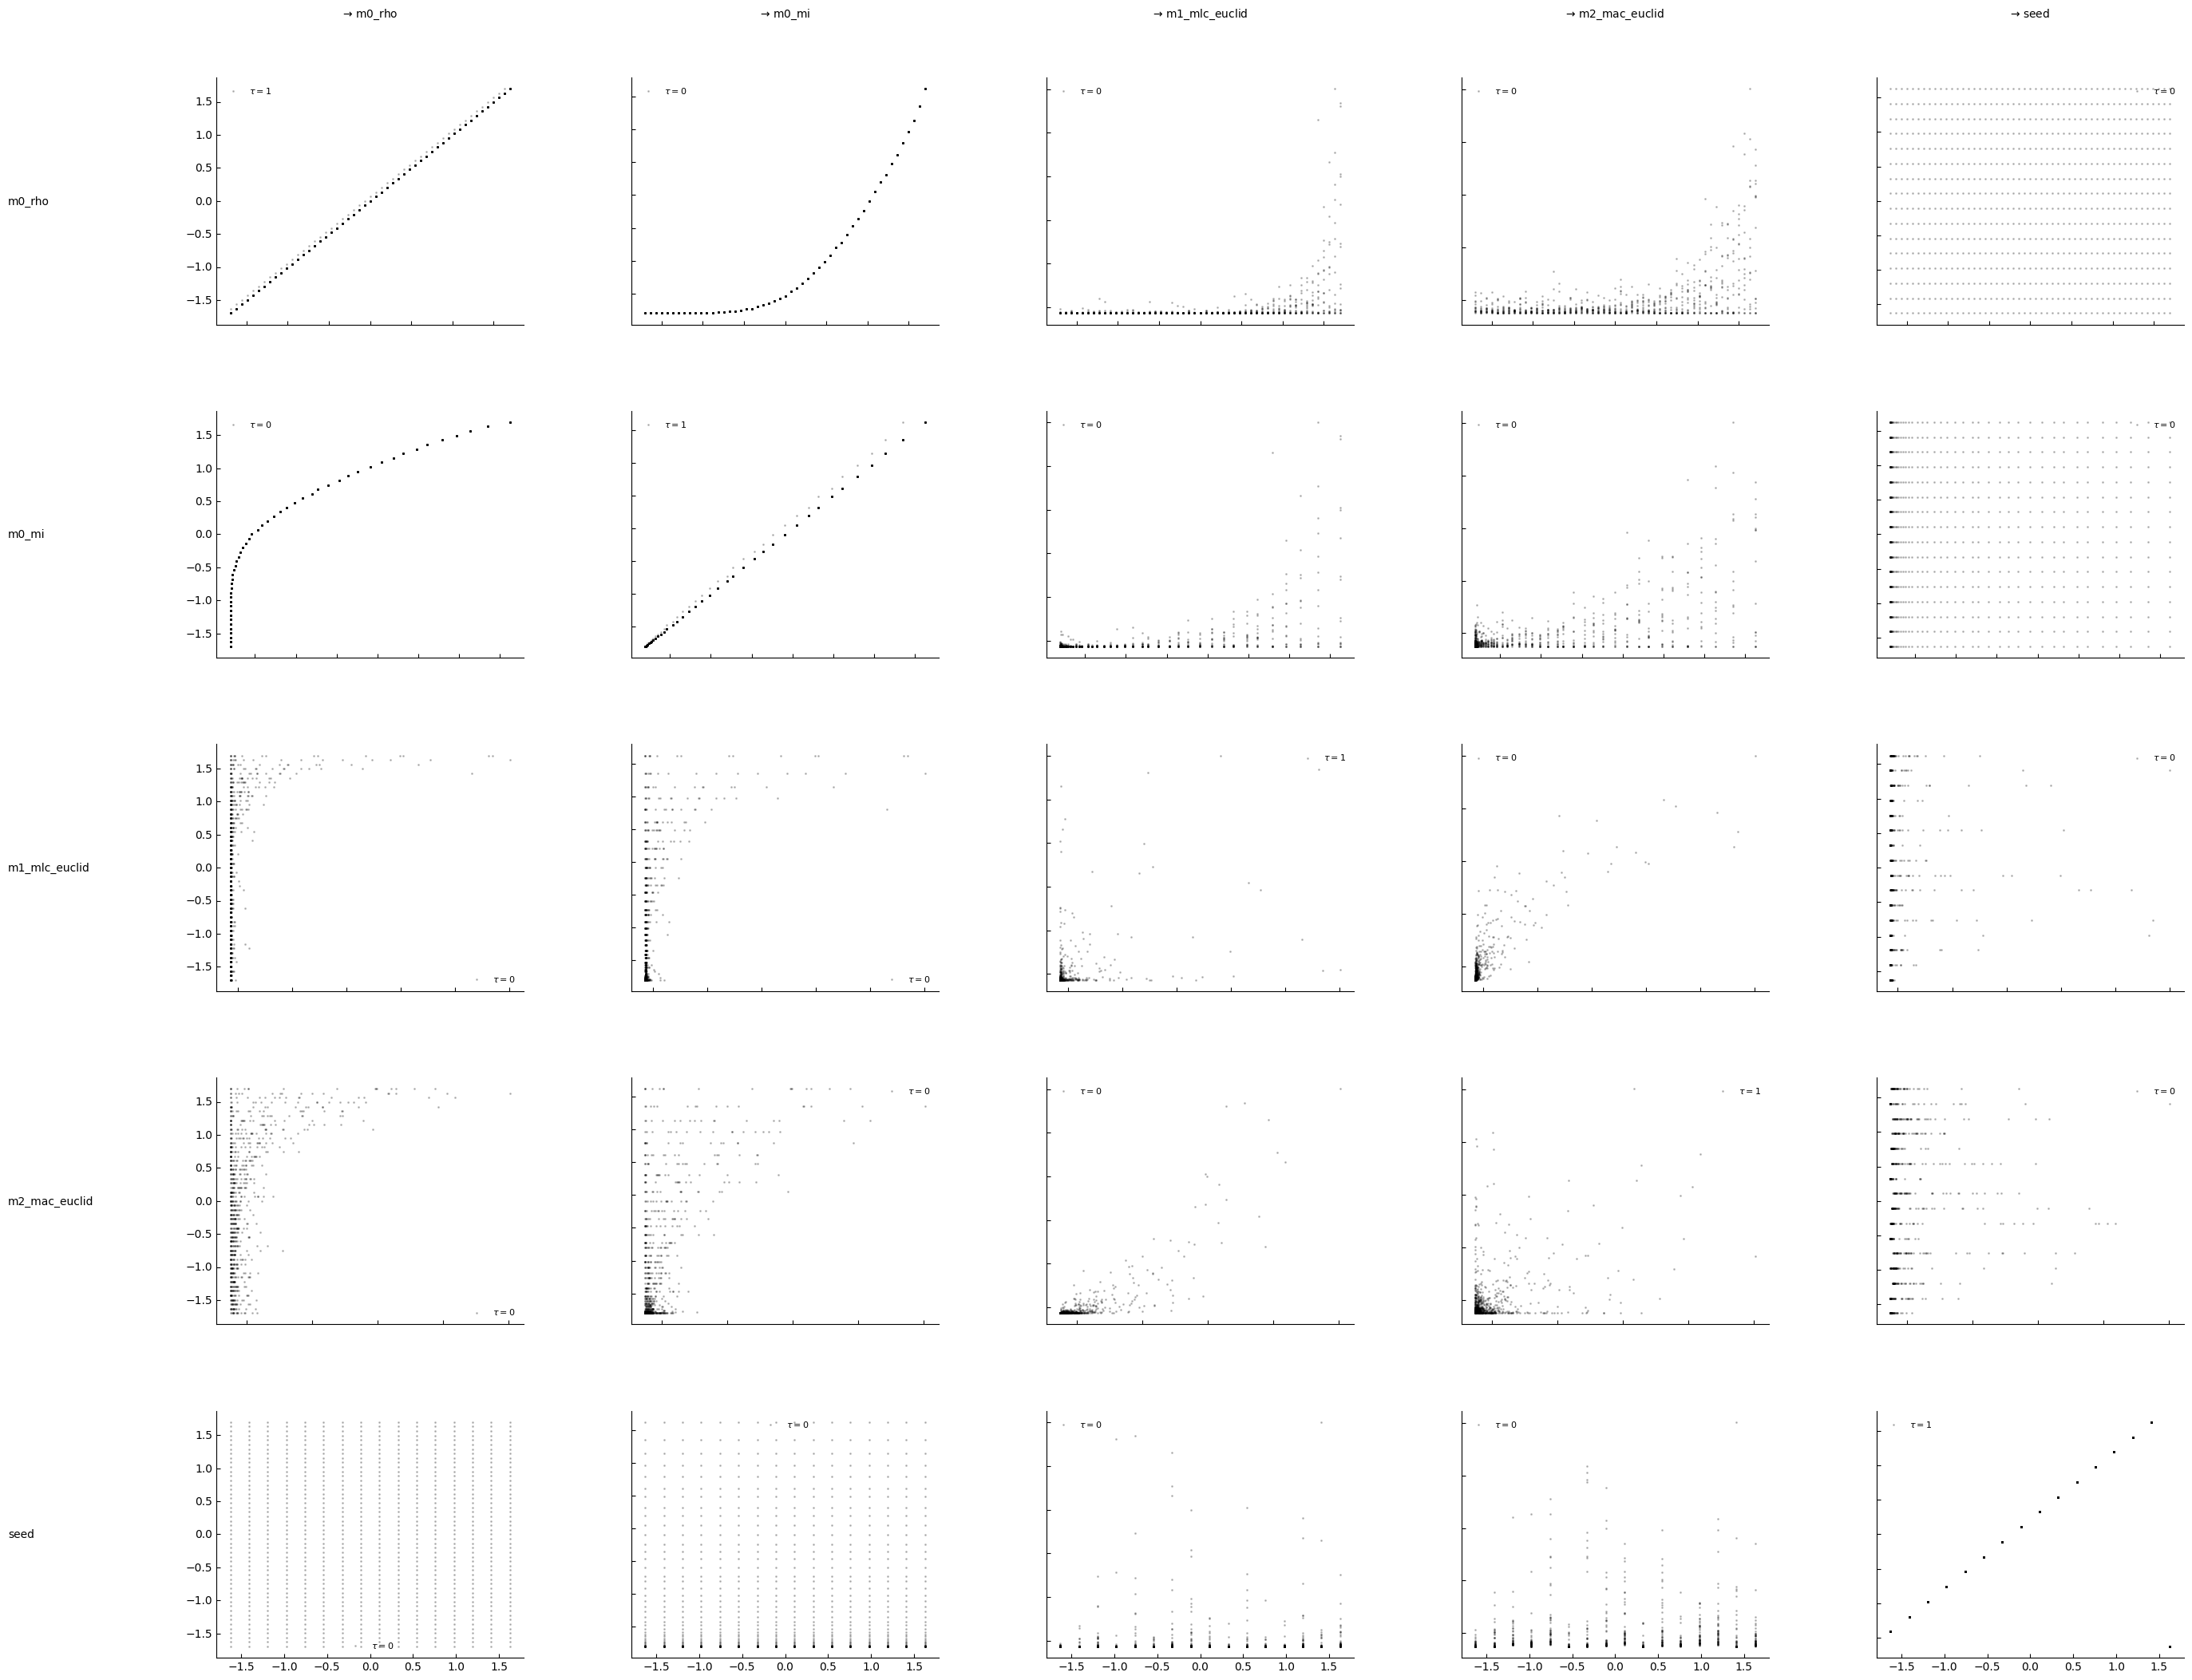

In [125]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
setup_args = {"figsize": (29,22),"label_space_left": 0.1,"label_space_top": 0.05}
tp.plot_scatterplots(dataframe=cleaneddf, add_scatterplot_args={'matrix_lags':matrix_lags}, 
                    setup_args=setup_args); plt.show()